In [35]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.11.0
The following GPU devices are available: 


In [36]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [37]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [38]:
import os
import urllib.request
import ssl


ssl._create_default_https_context = ssl._create_unverified_context


def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])


  display_image(image_with_boxes)


/var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/ipykernel_38164/4241748128.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to /var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/tmpjld8r650.jpg.
Found 100 objects.
Inference time:  7.759539365768433
Font not found, using default font.
Inference time: 7.810743093490601
Image downloaded to /var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/tmpvd2n62d0.jpg.


/var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/ipykernel_38164/4241748128.py:45: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
/var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/ipykernel_38164/4241748128.py:55: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


Found 100 objects.
Inference time:  7.299720048904419
Font not found, using default font.
Inference time: 7.351783990859985
Image downloaded to /var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/tmpbknaq63u.jpg.
Found 100 objects.
Inference time:  7.396815061569214
Font not found, using default font.
Inference time: 7.457594156265259


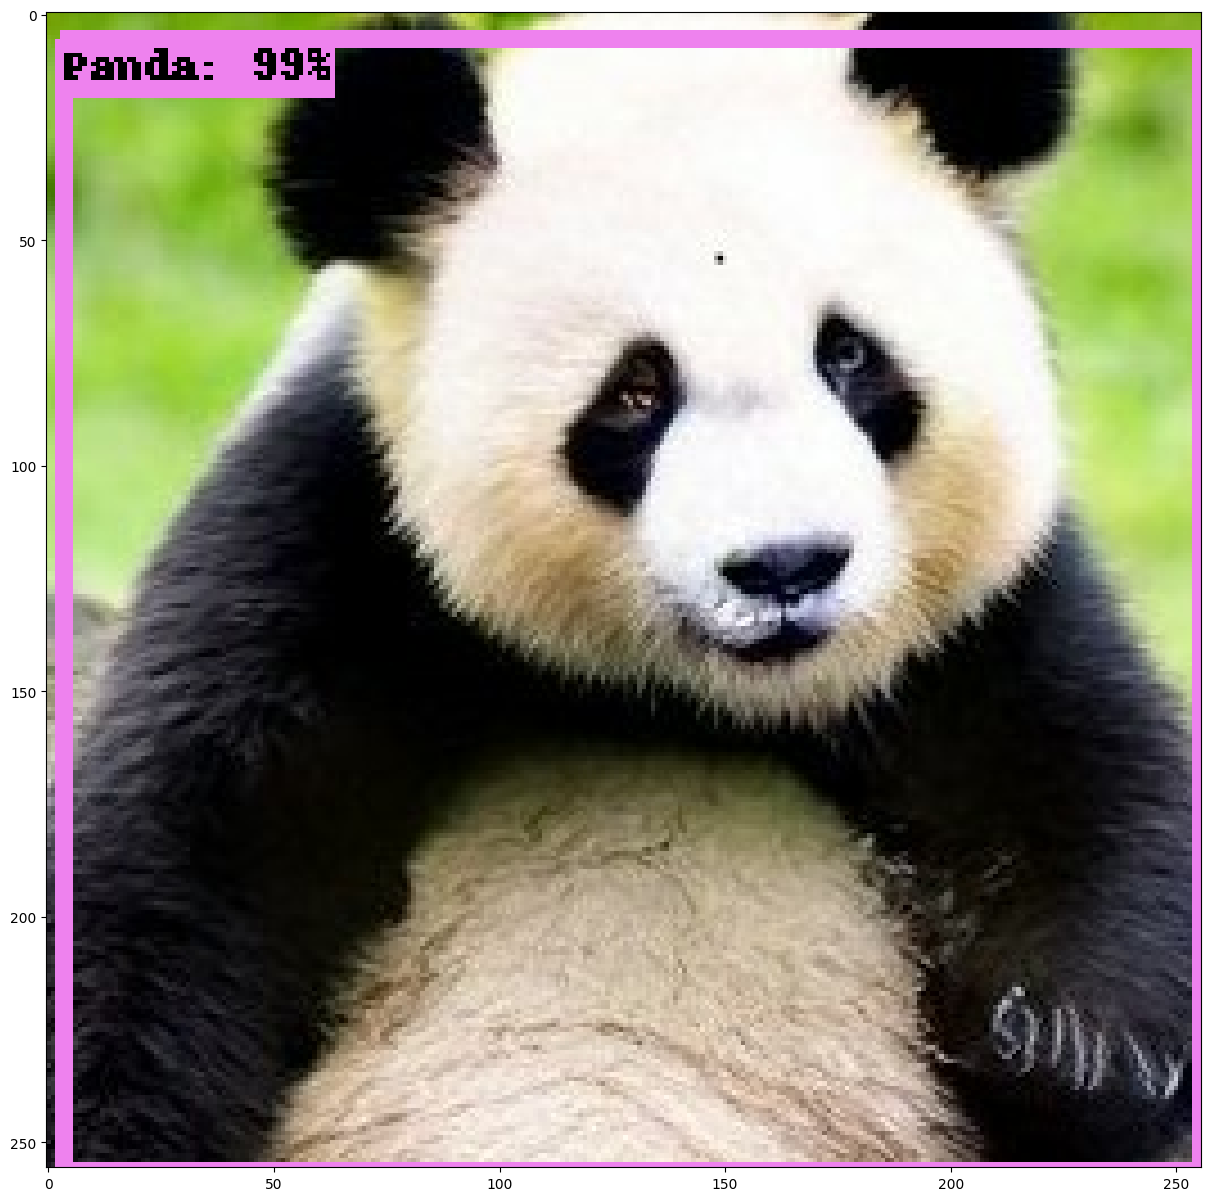

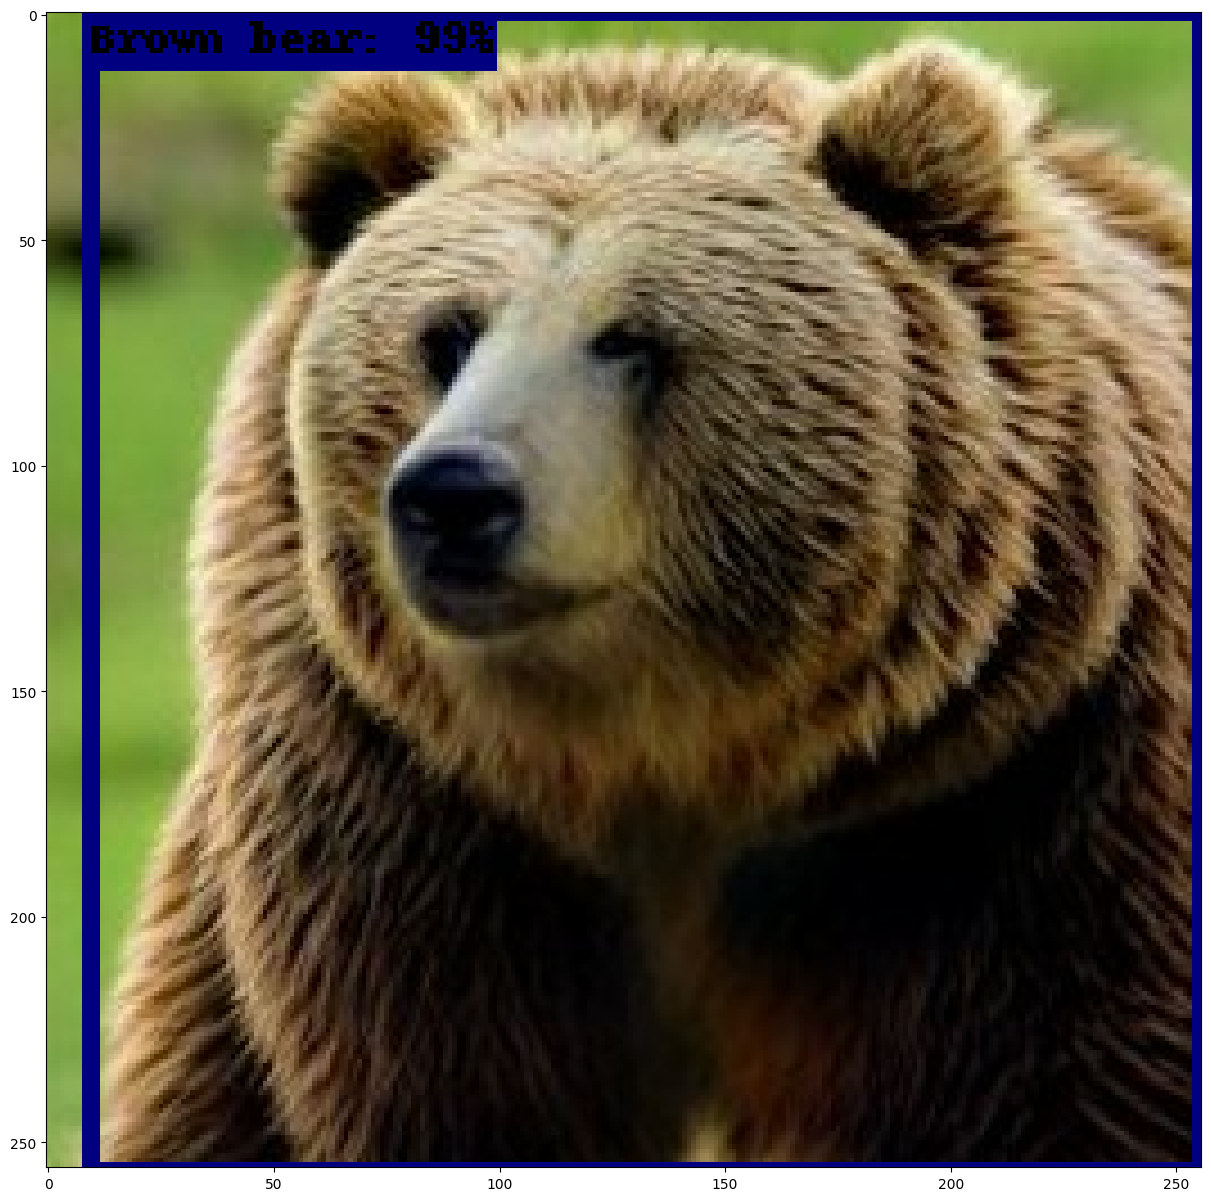

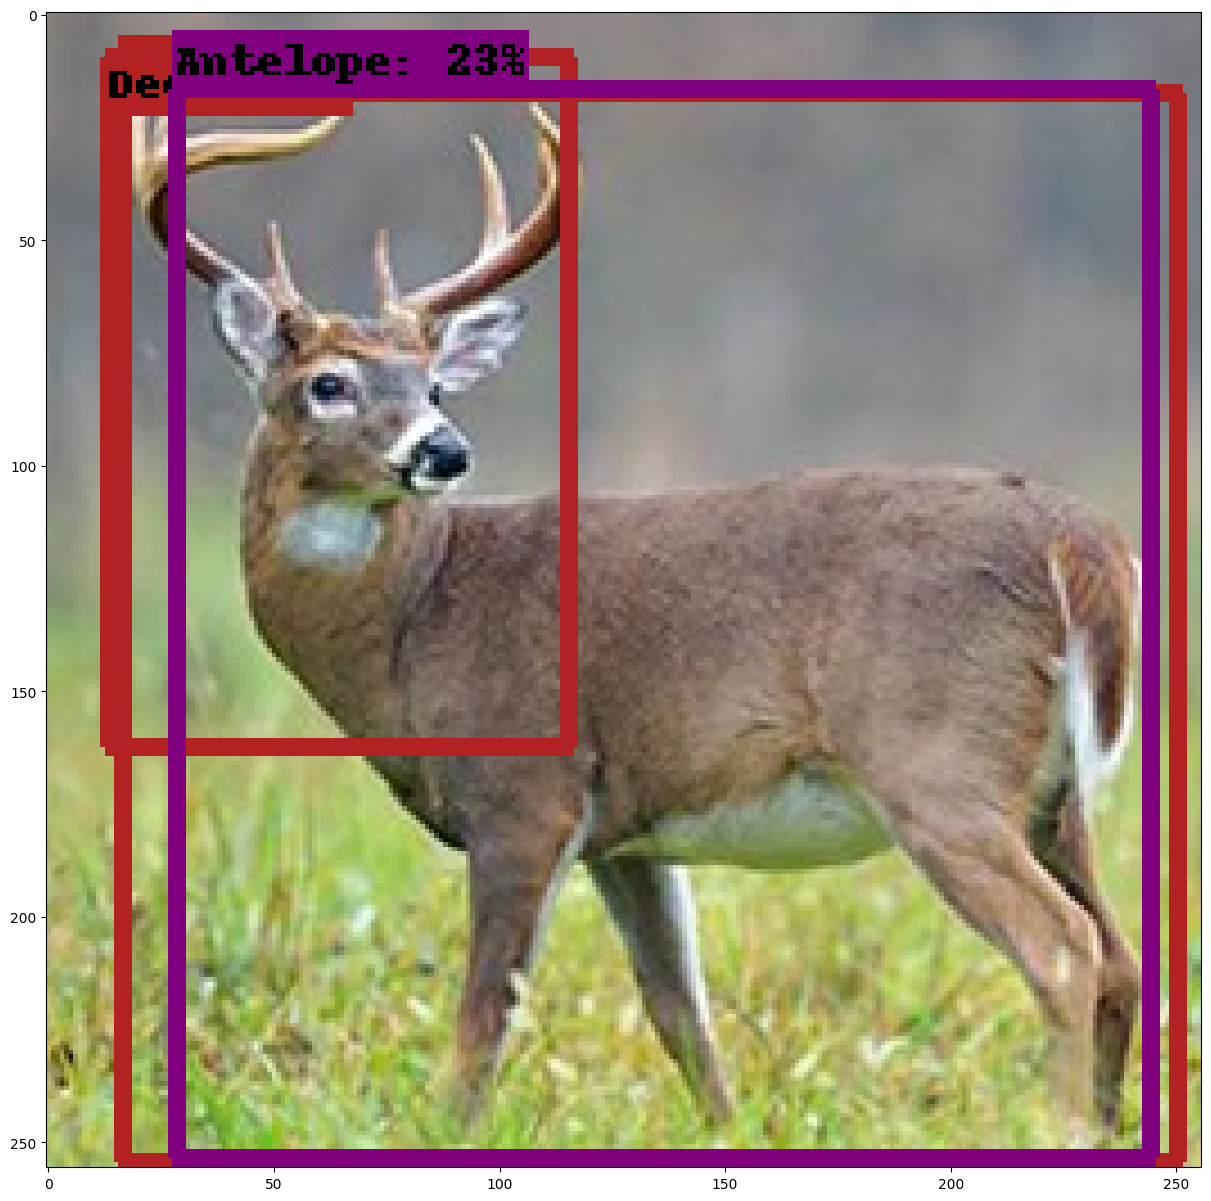

In [39]:
image_urls = [
 
  "https://raw.githubusercontent.com/Yyyoung6699/Coding2-python/main/coding2%20python/Bears/001.jpeg",
 
  "https://raw.githubusercontent.com/Yyyoung6699/Coding2-python/main/coding2%20python/Bears/002.jpeg",

  "https://raw.githubusercontent.com/Yyyoung6699/Coding2-python/main/coding2%20python/Bears/003.jpg",
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 256, 256)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

for i in range(len(image_urls)):
    detect_img(image_urls[i])
    
    

    

In [40]:
import os
import urllib.request
import ssl


ssl._create_default_https_context = ssl._create_unverified_context


def run_detector(detector, path, image_url):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])


  global class_names
  class_names = result["detection_class_entities"]
  global scores
  scores = result["detection_scores"]
  for x in range(len(class_names)):  
      if class_names[x] == b'Panda'and scores[x]>0.5:
          print(scores[x])
          filename = os.path.join('panda', 'panda.jpg')
          urllib.request.urlretrieve(image_url, filename)
          global content_url
          content_url = image_url  
          display_image(image_with_boxes)
 
  

  




/var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/ipykernel_38164/4241748128.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to /var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/tmp9r0uq745.jpg.
Found 100 objects.
Inference time:  7.781874179840088
Font not found, using default font.
0.9947944
Inference time: 7.862185955047607
Image downloaded to /var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/tmpvkfdu5j4.jpg.


/var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/ipykernel_38164/4241748128.py:45: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
/var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/ipykernel_38164/4241748128.py:55: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


Found 100 objects.
Inference time:  7.911011219024658
Font not found, using default font.
Inference time: 7.941035032272339
Image downloaded to /var/folders/bg/m39h84112zvclwh5yzzglrbm0000gn/T/tmp3bn27jrq.jpg.
Found 100 objects.
Inference time:  8.229639768600464
Font not found, using default font.
Inference time: 8.27273678779602


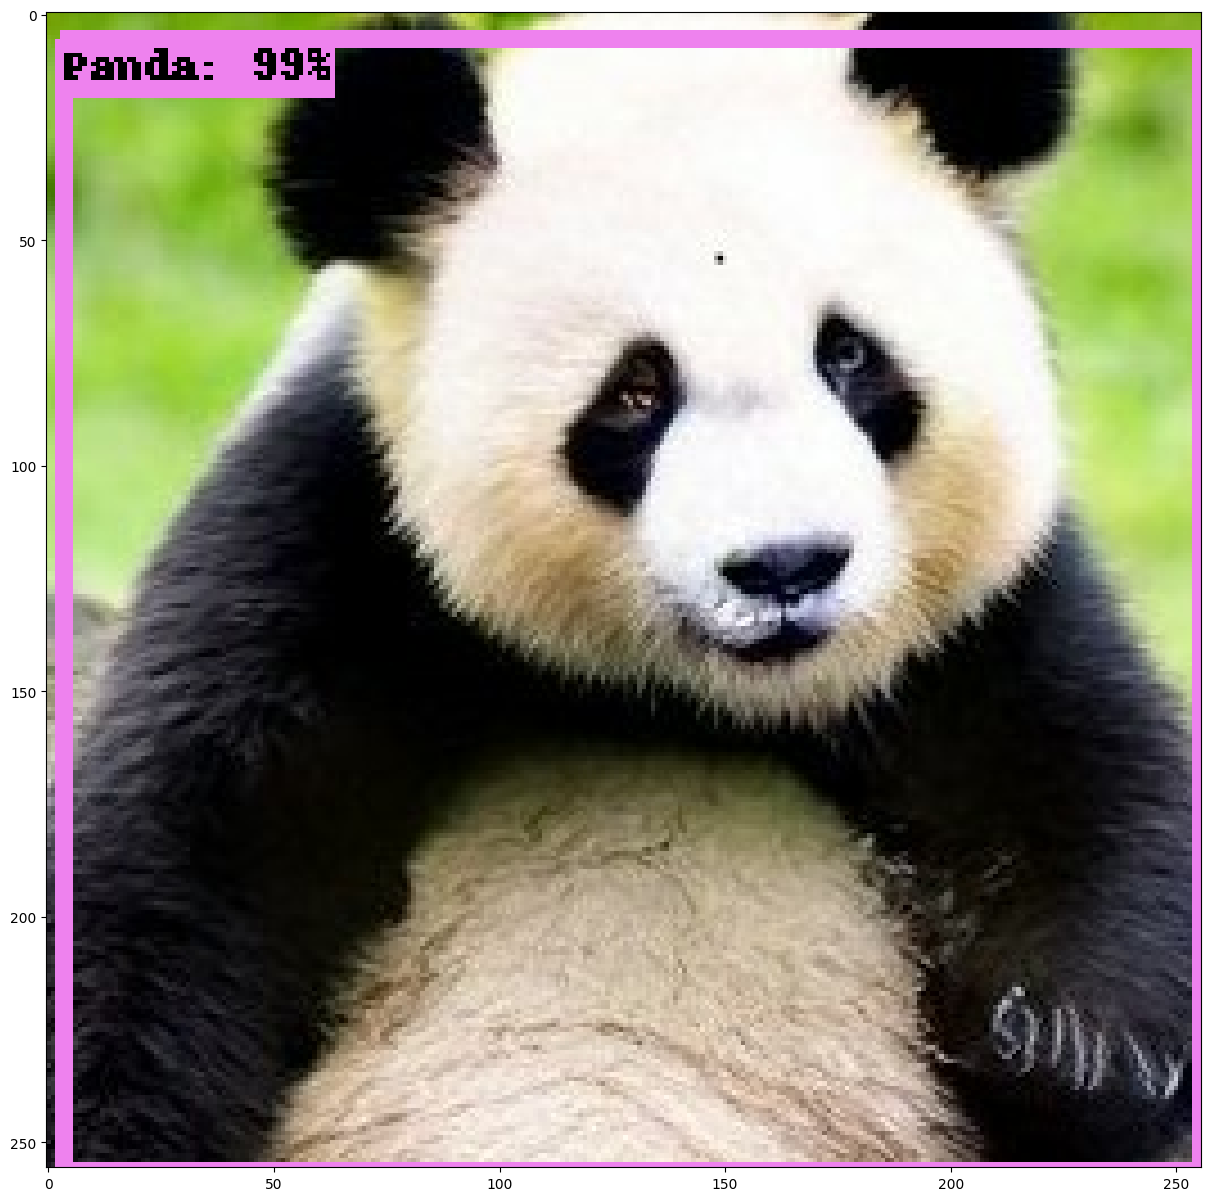

In [41]:
image_urls = [
 
  "https://raw.githubusercontent.com/Yyyoung6699/Coding2-python/main/coding2%20python/Bears/001.jpeg",
 
  "https://raw.githubusercontent.com/Yyyoung6699/Coding2-python/main/coding2%20python/Bears/002.jpeg",

  "https://raw.githubusercontent.com/Yyyoung6699/Coding2-python/main/coding2%20python/Bears/003.jpg",
]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 256, 256)
  run_detector(detector, image_path, image_url)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

for i in range(len(image_urls)):
    detect_img(image_urls[i])

In [42]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.11.0
TF-Hub version:  0.13.0
Eager mode enabled:  True
GPU available:  False


In [43]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

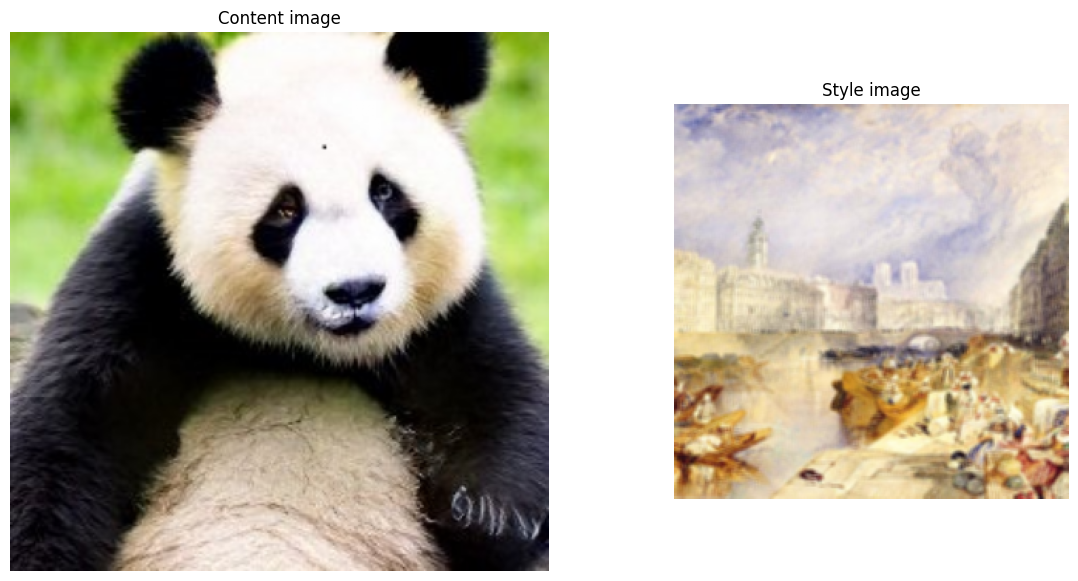

In [44]:
# @title Load example images  { display-mode: "form" }

content_image_url = content_url  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [45]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [46]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

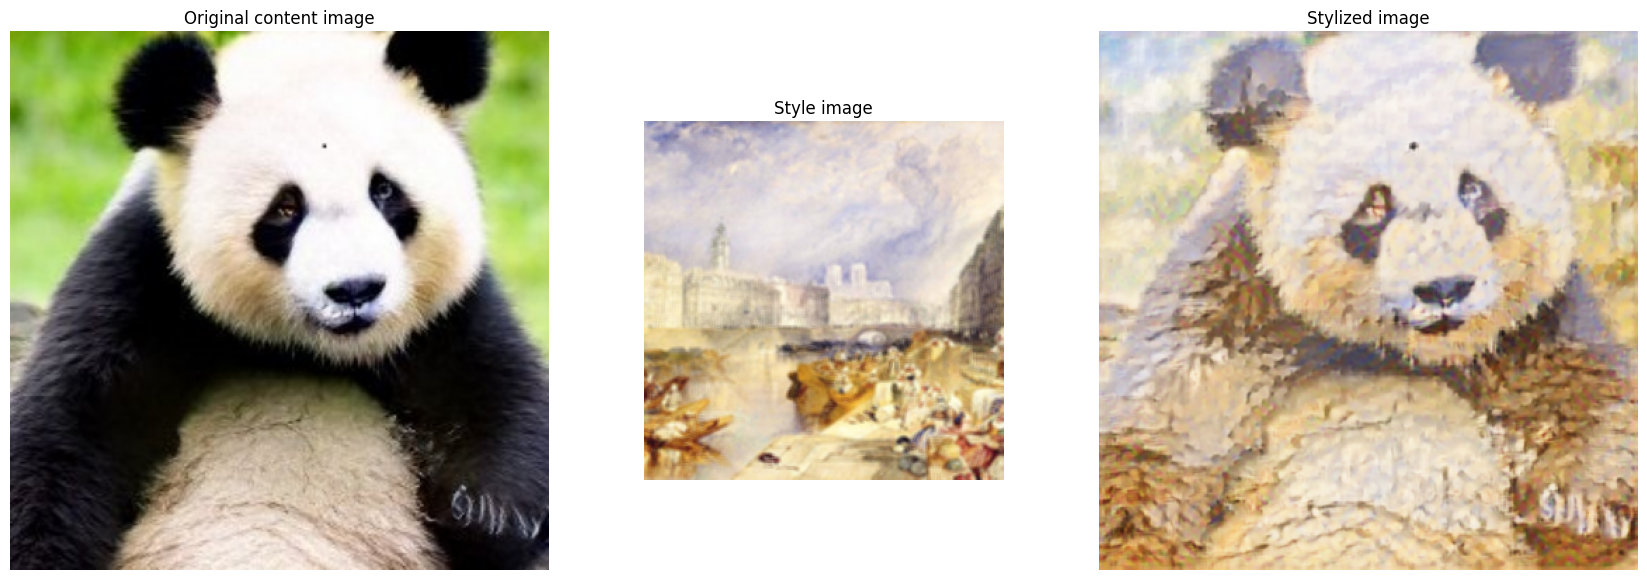

In [47]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])